# 15-388 Final Project: Predicting Airbnb Rental Prices in NYC
### By Sean Moore and Arjun Chidamabram

## Dependencies:

The libraries listed below are the dependencies required for this project. They can be installed via pip or using the conda-forge package.

In [1]:
# setup library importsS
import io, time, json
import requests
import random
import geopandas as gpd
import shapely
from geopy.geocoders import GoogleV3
import rtree
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Image
seaborn.set_style("white")
%matplotlib inline

## Main Objective and Motivation

In growing cities like NYC and Pittsburgh, there has been a lot of discussion about the recent effects of gentrification on the price of housing. Airbnb and fashionable restaurants are at the core of this debate. The basic premise is that as highly-demanded businesses are introduced to neighborhoods, the housing prices rise. Additionally, we believe Airbnb would be specifically interesting, because its price should directly correlate with housing prices. Additionally, we believe that the societal demand for part-time rentals should be represented in both the price of Airbnb and the ranking of restaurants. 

By gathering restaurant data , we seek to model these factors and ultimately predict these average prices for an Airbnb rental for one night in NYC. Our dataset consists of combined features from Yelp and Airbnb data. We hypothesize that features such as average yelp rating, average number of reviews, and average yelp price for a given zipcode will yield a strong correlation to average AirBnB one-bedroom listing prices for a given zipcode.

## Data Collection and Pre-Processing

We will begin by getting our AirBnB dataset from http://insideairbnb.com/get-the-data.html by simply downloading the flatfile and loading it as a pandas dataframe. 

In [2]:
#AIRBNB LISTINGS IN NYC:
airbnb = pd.read_csv("/Users/arjuncomputerscience/Desktop/datascienceproject/listings.csv")
#subset dataframe to get only the relevant columns
airbnb = airbnb[['zipcode','neighbourhood','city','bathrooms', 'bedrooms', 'beds','price','review_scores_rating', 'review_scores_location']].copy()
#convert price format from '$1,000.00' -> 1000.00
airbnb.price = airbnb.price.apply(lambda x: float(x[1:].replace(",",""))).astype("float64")

/Users/arjuncomputerscience/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43,61,62,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Next, we will similarly download our Zillow dataset from https://www.zillow.com/research/data/ choosing 'Zip Code' to be our be our geographic cut. After downloading and unziping the data we will load in the Median Rental Price for one bedrooms csv file as a pandas dataframe.


In [3]:
#ZILLOW LISTINGS BY ZIPCODE:
zil_rent_df = pd.read_csv("/Users/arjuncomputerscience/Desktop/datascienceproject/Zip_MedianRentalPrice_1Bedroom.csv")
#Rename a column of the data
zillow = zil_rent_df.rename(columns = {"2017-08" : "median_rental_price","RegionName" : "zip_code"})
#subset dataframe to get only the relevant columns
zillow = zillow[["zip_code","median_rental_price"]]

We will also need a simple html parser in order to web-scrape a list of all the nyc zip codes with BeautifulSoup. These will later be cross referenced with the number of zipcodes present within the Airbnb nyc dataset to form the a list of all the zipcodes used in the project.

In [4]:
def get_nyc_zip_codes(html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    root = BeautifulSoup(html, 'html.parser')
    zip_list = []
    table = root.find('table')
    for row in table.find_all('tr'):
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        zip_list.append(cols[0])
        zip_list.append(cols[3])
            
    return zip_list

website = requests.get("https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php")
nyc_zip_list = (get_nyc_zip_codes(website.content))
nyc_zip_list = (list(set(list(airbnb.zipcode.astype("str"))).intersection(set(nyc_zip_list))))

We seek to create a way to query and format restaurant data for each Zip Code in the nyc_zip_list variable just created. To do so we will be using the Yelp API and a lot of formatting. The code can be broken down as such. 

 The class YelpScraper contains our method for parsing the data-- it includes eight functions -- three of which were modified from HW1: read_api_key, yelp_search and all restaurants.  The all_restaurants function searches the top "num_res"(some integer value) amount of restaurants corresponding to the query for the yelp search. In our case, we are consistently querying for the yelp data corresponding to the zip-code of interest. This is done in our main function: get_nyc_yelp_data, which iterates through the list of zip-codes in our area and calls all_restaurants for each of those zip codes. Because the yelp API has limit on the number of requests that can be sent at a time to a given access key, we need to slow down how fast we query the api within our all_restaurants functions by sleeping the code on every iteration. As a result, gathering the data can be very time-consuming if either the number of zip-cdoes you are looking for or if your num_res parameter is set to high. 

At the same, however, if the num_res variable isn't set high enough, you won't be able to find enough restaurants corresponding with the zip code of an arbitrary iteration. This problem is magnified by the fact that the Yelp API search function does not limit itself to the zip code you are asking for. As result, if you query for 40 restaurants (num_res) it is possible that only end up with 5 restaurants that even correspond with your zip code. This presented a really large problem for the integrity of our dataset. This could potentially create a systematic bias in our data that could compromise our data set.  

To account for this in our final dataset, we set our num_res to query at least 150 restaurant name for every zip code and threw out data for any zip-code that didn't average over at least 25 restaurants: In the main get_nyc_yelp data function, you can set a min sample size by adjusting the bis_min parameter that you pass into the function and you can adjust the num_res parameter described earlier by adjusting the Bis_peek parameter. 

In [6]:
class YelpScraper:
    def read_api_key(self,filepath):
        """
        Read the Yelp API Key from file. Modified from HW1
        Args:
            filepath (string): File containing API Key
        Returns:
            api_key (string): The API Key
        """
        # feel free to modify this function if you are storing the API Key differently
        with open(filepath, 'r') as f:
            return f.read().replace('\n','')
    
    def yelp_search(self,api_key, query):
        """
        Make an authenticated request to the Yelp API.
        Modified from HW 1
        Args:
            query (string): Search term
        Returns:
            total (integer): total number of businesses on Yelp corresponding to the query
            businesses (list): list of dicts representing each business
        """
        headers = {
            "authorization": "Bearer %s" % api_key
        }
        params = {
            'location': query
        }                     
        response = requests.get('https://api.yelp.com/v3/businesses/search', headers=headers, params=params)
        jsonOb = response.json()  
        bizList = jsonOb['businesses']
        bizCount = jsonOb['total']
        return (bizCount, bizList)
    
    def all_restaurants(self,api_key, query, num_res):
        """
        Also modified from HW1, 
        Retrieve ALL the restaurants on Yelp for a given query.
        Args:
            api_key (string): allows access to yelp API
            query (string): Search term (zip code)
            num_res : Must be less than one thousand or else code will throw an error. 
        Returns:
            results (list): list of dicts representing each business
            returns an empty []
        """
        retlist = []
        offset = 0
        params = {'location': query, 'categories':'restaurants','limit':20, 'offset':offset}
        headers = {
            'Authorization': 'Bearer %s' % api_key,
        }
        response = requests.get("https://api.yelp.com/v3/businesses/search",headers=headers,params=params)
        response = response.json()
        if ('businesses' and 'total') not in response:
            return retlist
        retlist += response['businesses']
        total = response['total']
        if (total > num_res):
            total = num_res
        offset += 20
        params['offset'] = offset
        count = 0
        while(offset < total):
            response = requests.get("https://api.yelp.com/v3/businesses/search",headers=headers,params=params)
            response = response.json()
            count += 1
            retlist += response['businesses']
            offset += 20
            params['offset'] = offset
            time.sleep(0.2)
        return retlist
    
    def getCategoryList(self,listOfDict):
        total_list = []
        for i in listOfDict:
            ithCat = i["title"]
            total_list.append(ithCat)
        return total_list
    
    def listOfDictToDF(self, results, zip_code):
        """
        Retrieve ALL the restaurants on Yelp for a given query.
        Args:
            results (list): list of dicts representing each business
            zip_code (string zip code)
        Returns:
            listoflists (list of lists each index is relevant feature): list of dicts representing each business
        """
        #remove all dict with no keys 
        new_results = []
        len_rest = len(results)   
        for i in range(len_rest):
            if "location" in results[i]:
                if "zip_code" in results[i]["location"]:
                    if ("name" and "rating" and "review_count" and "price" and "categories") in results[i]:
                        if (results[i]["review_count"] > 10):
                            new_results.append(results[i])
        new_len = len(new_results)
        list_of_places = []
        count = 0
        for i in range(new_len):
            adressDict = new_results[i]['location']
            zip_i = adressDict['zip_code']
            if (zip_i == zip_code):
                #get rating, review_count, price, categories, name
                try:
                    price = new_results[i]['price']
                    name = new_results[i]["name"]
                    rating = new_results[i]['rating']
                    review_count = new_results[i]['review_count']
                    category_list = self.getCategoryList(results[i]["categories"])
                    zip_code = zip_i
                    #categories = results[i]['categories']
                    i_bis_list = [name, rating, review_count, zip_i, price, category_list]
                    list_of_places.append(i_bis_list)
                except KeyError:
                    print("Key Error: Error this business will not be included")     
            else:
                #count helpful for finding happy medium for data size and integrity v.s. speed and percentage (accuracy))
                count += 1
        return list_of_places
    
    def top_n_categories(self,counter_dict_obj, n):
        boa = counter_dict_obj.most_common(n)
        onlyCats = [i[0] for i in boa]
        return onlyCats
    def get_zip_code_avg(self,zip_code, api_key, bis_peek, two_d_rest):
        """
        gets the avg rank from list of lists
        Args:
            zip_code (str) : gets the zip code that will be investigated 
            api_key (string): code that is used from text files
            bis_peek (int): number of restaurants that will be explored in search  
            two_d_rest (list of list) : 2 d list --- each list representing every business corresponding with zip code 
        Returns:
             pd_lst_of_place (pd data frame): zip code avg. rating, avg. review_count, zip_code, avg. dollar signs, top cat 
        """
        #will normalize these values later and add to a row with zip code
        rating_list = []
        count_list = []
        price_list = []
        cat_list = []
        num_bus = len(two_d_rest)
        #name, rating, review_count, price
        for bus in two_d_rest:
            rating_list.append(bus[1])
            count_list.append(bus[2])
            price_list.append(len(bus[4]))
            cat_list.extend(bus[5]) 
        cat_dict = Counter(cat_list)
        cat_top_5 = self.top_n_categories(cat_dict, 5)
        rating_avg = sum(rating_list) / num_bus
        count_avg = sum(count_list) / num_bus
        price_avg = sum(price_list) / num_bus
        zip_avgs = [zip_code, rating_avg, count_avg, price_avg, cat_top_5, num_bus]
        return zip_avgs
    
    def get_nyc_yelp_data(self,zip_codes, api_key, bis_peek, bis_min):
        """
        gets the avg rank from list of lists 
        Args:
            list of zipcodes (strings):
            api_key (string): code that is used from text files
            bis_peek (int): number of restaurants that will be explored in search
            bis_min (int): minimum number of restaurants that zip code must have to consider it
        
        Returns:
             pd_lst_of_place (pd data frame): list of dicts representing each business
                            [zip, avg stars, review count, avg. $ sign count, num_biz]
        """
        yelp_data = []
        count = 0
        for zipee in zip_codes:
            #will try to search for first #bis_peek number of restaurants
            count += 1
            print(zipee, count, "out of", len(zip_codes))
            json_rest = self.all_restaurants(api_key, zipee, bis_peek)
            two_d_rest = self.listOfDictToDF(json_rest, zipee)
            if (len(two_d_rest) > bis_min):
                zipee_data = self.get_zip_code_avg(zipee, api_key, bis_peek, two_d_rest)
                yelp_data.append(zipee_data)
            time.sleep(.2)
        return yelp_data

In [7]:
#EXAMPLE of Scraping restaurant data for a single zipcode:
yelp_scraper = YelpScraper()
#extracts API KEY
API_KEY = yelp_scraper.read_api_key("/Users/arjuncomputerscience/Desktop/datascienceproject/api_key.txt")
#scrapes the first 20 resstaurants for the zipcode 10001
restuarants = yelp_scraper.all_restaurants(API_KEY, "10001", 20)
#to get our final yelp dataset we do: (THIS can be very time consuming and has thus been commented out )
#nyc_yelp_dataset = yelp_scraper.get_nyc_yelp_data(nyc_zip_list, API_KEY, 150, 10)
#
#nyc_yelp_dataset = pd.DataFrame.from_records(nyc_avg_10, columns = ["zip_code","avg_rating","avg_num_reviews","avg_price","categories","restaurant_count"])

More Preprocesing:

In [18]:
yelp_before_merge = pd.DataFrame.from_records(nyc_yelp_dataset, columns = ["zip_code","avg_rating","avg_num_reviews","avg_price","categories","restaurant_count"])
yelp_before_merge.zip_code = yelp_before_merge.zip_code.astype('int32')

In [ ]:
#process the airbnb data before merging with the yelp data!
airbnb1 = airbnb.loc[airbnb['bedrooms'] == 1]
bnb = airbnb1.groupby('zipcode')
num_places = bnb['zipcode'].count()
price = bnb['price'].mean()
review_scores_rating = bnb["review_scores_rating"].mean()
review_scores_location  = bnb['review_scores_location'].mean()
bathrooms = bnb['bathrooms'].mean()
beds = bnb["beds"].mean()
airbnbfinal = pd.DataFrame({"num_of_listings":num_places,"yelpprice":price,"review_scores_rating" : review_scores_rating,"review_scores_location" : review_scores_location,"bedcount":beds})
airbnbfinal.reset_index(inplace=True)
airbnbfinal = airbnbfinal.rename(columns = {"zipcode":"zip_code"})
df2 = pd.merge(airbnbfinal,yelp_before_merge, on ='zip_code', how ='inner')
df2.to_csv(path_or_buf = "main_dataset.csv")

## Exploratory Data Analysis and Geolocative Visualizations

In order to create our chloropleth maps and geolocative visualizations we need to load our new york city.shp file from the public data-set https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data

In [5]:
#load the shape file
df_zip_nyc = gpd.read_file("/Users/arjuncomputerscience/Desktop/datascienceproject/Neighborhood_nyc/ZIP_CODE_040114.shp")
df_zip_nyc.ZIPCODE = df_zip_nyc.ZIPCODE.astype('int32')

Gathering the dataset used can be rather time consuming and challenging. Although we have provided a thorough guide of how to do this in the section prior, we have also included a csv file of the gathered data. This dataset contains a merged dataframe of Airbnb data of 1 bedroom listings for each zipcode merged with the corresponding restaurant data. We will load this data below:

In [6]:
precurated_data = pd.read_csv("/Users/arjuncomputerscience/Desktop/datascienceproject/main_dataset.csv")
#getting this dataset ready to merge with that of the df_nyc_zip
ready_to_merge = precurated_data.rename(columns = {"zip_code" : "ZIPCODE"})
ready_to_merge.ZIPCODE = ready_to_merge.ZIPCODE.astype('int32')

Before merging we see that the population of NYC is 8,398,606 people. This is for all of the zip codes in NYC. Let us merge the data together and see how much the population is for only the zipcodes used in the analysis.

In [7]:
#total population of NYC
df_zip_nyc.loc[:,"POPULATION"].sum()

8398606.0

In [8]:
#Merge
yelp_airbnb = pd.merge(df_zip_nyc, ready_to_merge,on = "ZIPCODE",how = "inner")
yelp_airbnb.loc[:,"POPULATION"].sum()

7361121.0

We see that despite taking less than half of the Zip Codes in NYC, we still retain a majority of the population, 7,361,121 people to be exact!

In [9]:
yelp_airbnb = yelp_airbnb.rename(columns = {"yelpprice": "bnb_rent_price", "ZIPCODE": "zip_code",
                                       "avg_rating":"avg_yelp_rating", "avg_num_reviews": "ylp_reviews_per_zip",
                                       "review_scores_location": "bnb_location_rating", 
                                        "review_scores_rating":"bnb_rating_overrall","avg_price": "yelp_price"})



### Average Yelp Price per Zip-Code in NYC

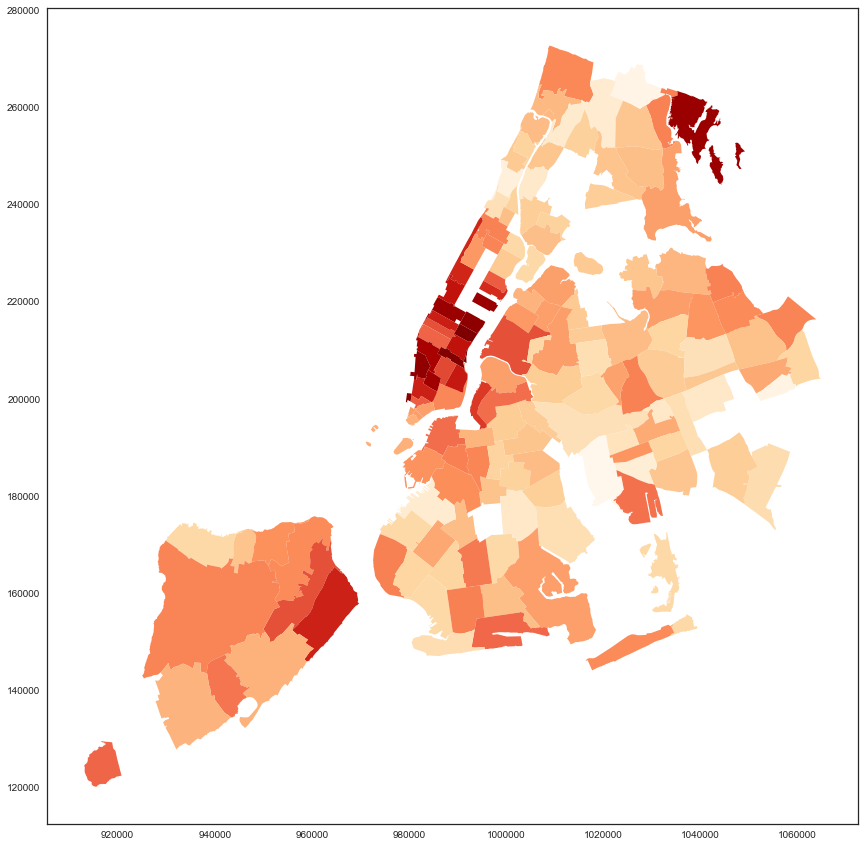

In [10]:
yelp_airbnb.plot(figsize=(15,15), column = 'yelp_price', cmap= "OrRd");

### Average Airbnb rental price per Zip-Code in NYC

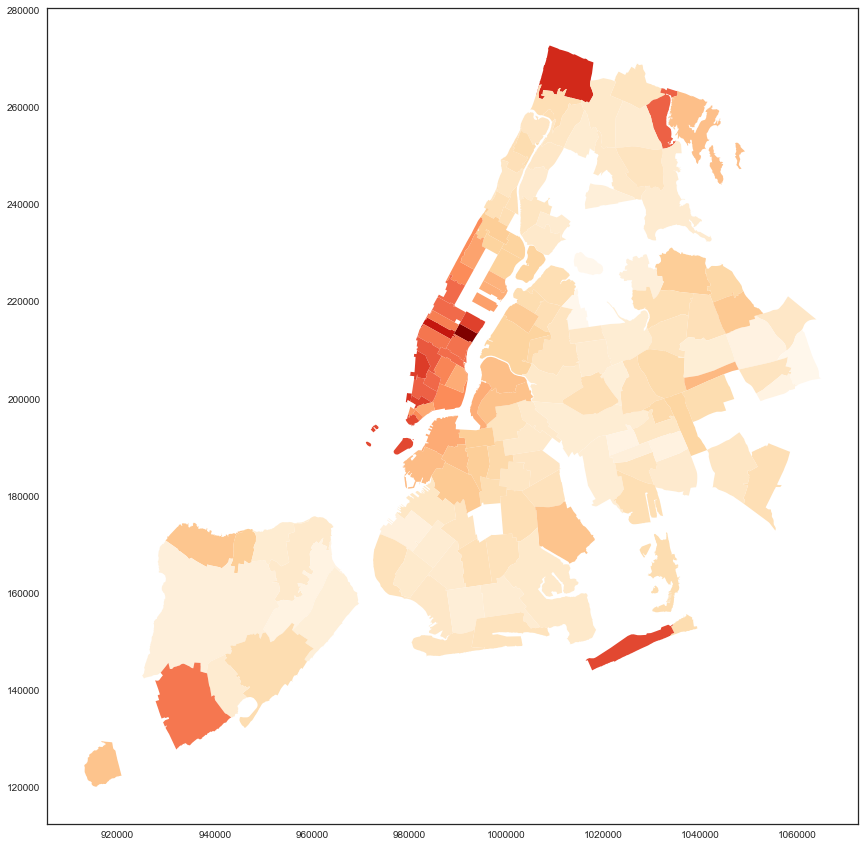

In [12]:
yelp_airbnb.plot(figsize = (15,15),column = 'bnb_rent_price', cmap= "OrRd")

One of the assumptions that we made in our hypothesis was that Airbnb is strongly correlated with the price of rent. Comparing this map to the previous map demonstrates this correlation visually. 

### Average Yelp Rating per Zip-Code in NYC

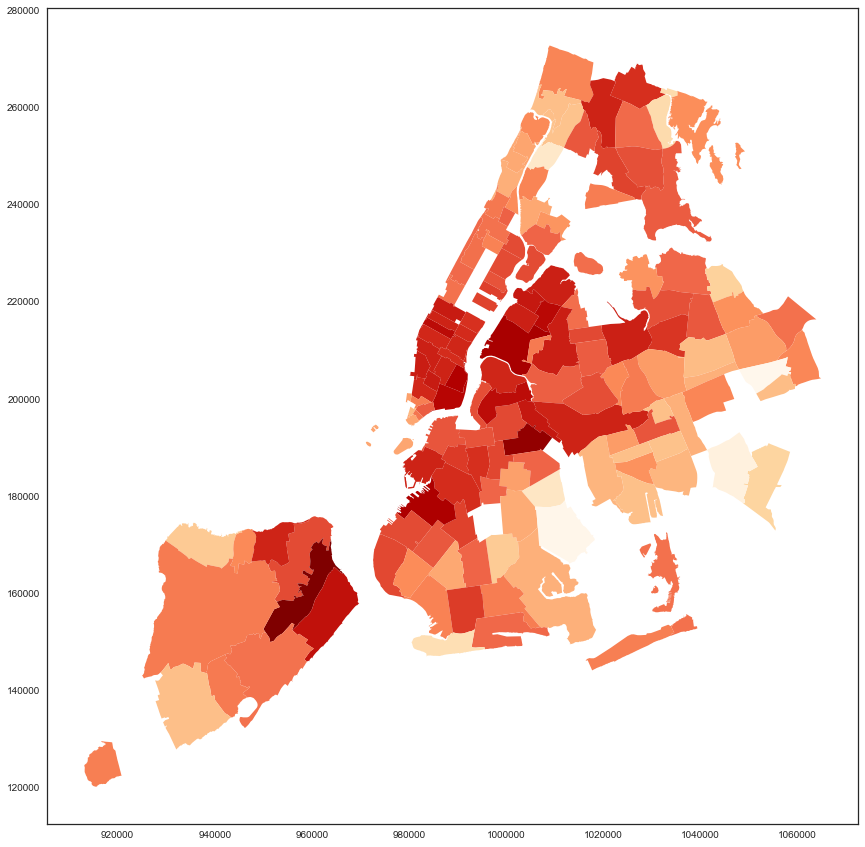

In [13]:
yelp_airbnb.plot(figsize = (15,15),column = 'avg_yelp_rating', cmap= "OrRd")

Additionally, Yelp price and Yelp rating seem to be related-- this can follow from two general facts: 1. Better restaurants can afford to charge their customers more 2. Restaurants in more expensive areas in the city have to be succesful with customers in order to survive. 

### Number of Yelp reviews per Zip-code in NYC

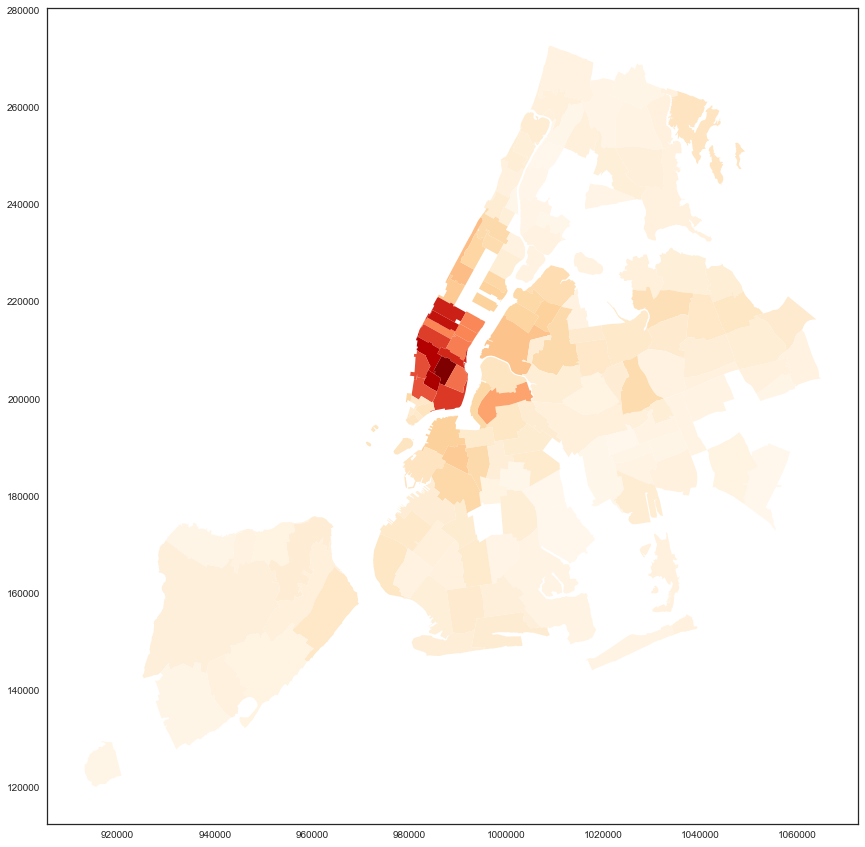

In [15]:
yelp_airbnb.plot(figsize = (15,15),column = 'ylp_reviews_per_zip', cmap= "OrRd")

Here we see a different distribution within this feature. This shows us that very particular areas had many more reviews than others. 

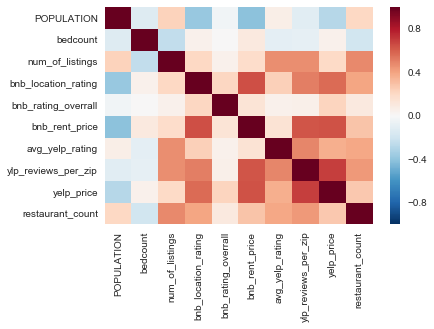

In [16]:
corr = yelp_airbnb[["POPULATION","bedcount","num_of_listings","bnb_location_rating","bnb_rating_overrall","bnb_rent_price","avg_yelp_rating","ylp_reviews_per_zip","yelp_price","restaurant_count"]].corr() 
seaborn.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values)

We performed a correlation matrix heat map to understand what variable corerlate with one another. Some of the interesting correlations we noticed were that the number of air bnb listings was moderately correlated with number of restaurants. Furthermore, we noticed that Airbnb rent price had a strong positive correlation with both Yelp Price and the number of Yelp reviews for a given zip code. This is reaffirms our hypothesis and gives us insight showing that neighborhoods with more expensive restaurants and that are reviewd more often are correlated with the average Airbnb price of a zip code. There are a lot more interesting correlations that can be seen from the matrix that you should definitely take a look at.

### Univariate Analyis of features

Airbnb Rental Price Histogram

(array([ 26.,  65.,  16.,  14.,   8.,   9.,  10.,   5.,   1.,   1.]),
 array([  39.        ,   60.40365854,   81.80731707,  103.21097561,
         124.61463415,  146.01829268,  167.42195122,  188.82560976,
         210.22926829,  231.63292683,  253.03658537]),
 <a list of 10 Patch objects>)

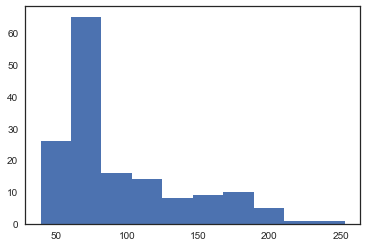

In [22]:
plt.hist(yelp_airbnb.bnb_rent_price)

The histogram of Airbnb Rent Prices shows a right skewed distribution with a peak at around 75 dollars a night. This is expected with rent prices as there are some outlier listings such as penthouses, and luxury Airbnbs that skew the data.

Average Yelp Rating Histogram

(array([  3.,   3.,   5.,  13.,  25.,  33.,  33.,  30.,  12.,   2.]),
 array([ 2.86363636,  3.00539773,  3.14715909,  3.28892045,  3.43068182,
         3.57244318,  3.71420455,  3.85596591,  3.99772727,  4.13948864,
         4.28125   ]),
 <a list of 10 Patch objects>)

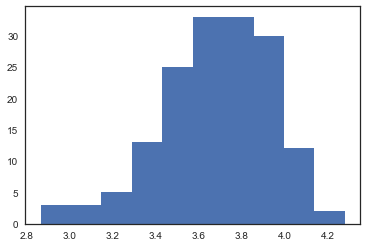

In [19]:
plt.hist(yelp_airbnb.avg_yelp_rating) 

We see that the average Yelp rating was in betwen 3.5 and 4.1. This means that there were not as many restaurants with low reviews or extremely high reviews. This is also expected as people's reviews tend to average out and extremes are never seen too much.

Reviews sampled from Restaurants per Zip-code Histogram

(array([ 48.,  44.,  26.,   6.,  11.,   5.,   2.,   1.,   1.,   0.,   4.,
          1.,   0.,   2.,   2.,   2.,   1.,   2.,   0.,   1.]),
 array([   24.84615385,    77.44809394,   130.05003404,   182.65197413,
          235.25391423,   287.85585432,   340.45779442,   393.05973451,
          445.66167461,   498.2636147 ,   550.8655548 ,   603.46749489,
          656.06943499,   708.67137509,   761.27331518,   813.87525528,
          866.47719537,   919.07913547,   971.68107556,  1024.28301566,
         1076.88495575]),
 <a list of 20 Patch objects>)

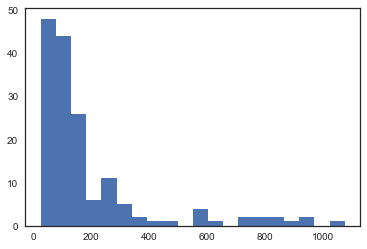

In [22]:
plt.hist(yelp_airbnb.ylp_reviews_per_zip, bins = 20)

We see that yelp_reviews per zipcode are heavily right skewed. This is because there are a few zipcodes that are known to be food hubs in NYC. These hubs are reviewed a lot creating this distribution. However, the majority of zipcodes have around 25-50 average reviews.

Number of restaurants per zip-code Histogram

(array([ 39.,  32.,  15.,  17.,  17.,  18.,  11.,   6.,   2.,   2.]),
 array([  11. ,   24.5,   38. ,   51.5,   65. ,   78.5,   92. ,  105.5,
         119. ,  132.5,  146. ]),
 <a list of 10 Patch objects>)

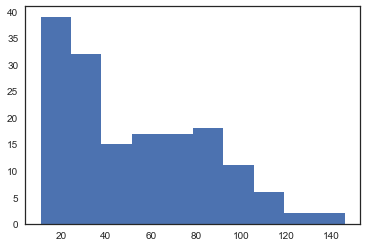

In [23]:
plt.hist(yelp_airbnb.restaurant_count)

The restaurant count is also right skewed for similar reasons as the plot above.

### Bivariate Analyis of features

Yelp Rating v.s. Airbnb rent price

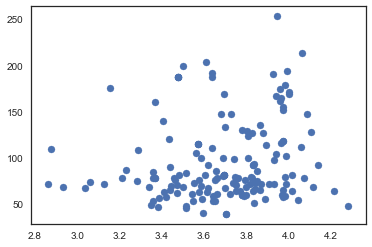

In [25]:
plt.scatter(yelp_airbnb.avg_yelp_rating, yelp_airbnb.bnb_rent_price)

We see some basic trends such that when yelp_rating increases so does bnb rental prices. Although there is some noice this general trend is visible.

Yelp rating v.s. Number of Restaurants

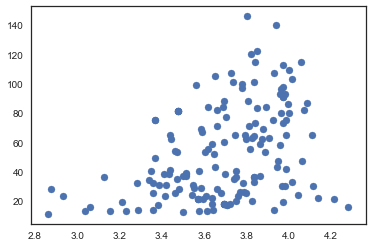

In [26]:
plt.scatter(yelp_airbnb.avg_yelp_rating,yelp_airbnb.restaurant_count)

The same trend as before is also noticed for the number of restaurants when compared to the yelp average review.

Number of Restaurants v.s. Airbnb rental Price

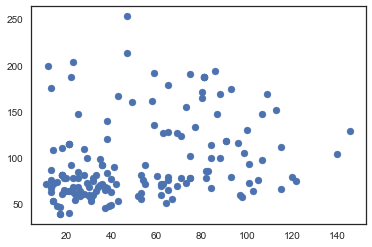

In [27]:
plt.scatter(yelp_airbnb.restaurant_count,yelp_airbnb.bnb_rent_price)

Here we don't see as much of a correlation other than a significant cluster at the bottom left. This means that when there are a few restaurants nearby the airbnb prices also tend to be lower.

Avg. amount of Reviews v.s. Rental price of Airbnb

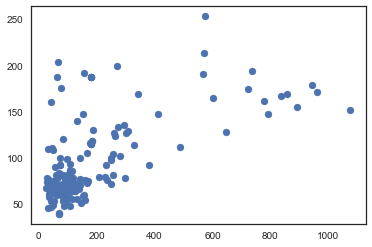

In [28]:
plt.scatter(yelp_airbnb.ylp_reviews_per_zip,yelp_airbnb.bnb_rent_price)

A similar trend is also noticed for number of reviews per zipcode and airbnb prices.

## Simple Linear Model

We will now run a simple linear regression model and assess the performance.

In [16]:
import time
from sklearn import linear_model
from sklearn.model_selection import train_test_split
random.seed(15388)
features = ["POPULATION","bedcount","num_of_listings","bnb_location_rating","bnb_rating_overrall","avg_yelp_rating","ylp_reviews_per_zip","yelp_price","restaurant_count"]
yelp_airbnb = yelp_airbnb.dropna()
X = yelp_airbnb[features]
y = yelp_airbnb.bnb_rent_price
Xtrain,Xtest, ytrain, ytest = train_test_split(np.asarray(X),np.asarray(y), test_size = 0.2)
reg = linear_model.LinearRegression()
reg.fit(Xtrain,ytrain)
pred_array = reg.predict(Xtest)
mse = np.mean((ytest- pred_array)**2)
print(np.sqrt(mse))
print(reg.score(Xtest,ytest))


21.6440200222
0.679501060503


A simple linear model is a great algorithm to try out for regression. We see that the square root of the MSE is 27.8. This means that our model was off by 21.6 dollars per night on average. This is not that bad when considering that the prices for airnbnb rentals for a night are around 75-100 on average. Furthermore, we see that an R squared value of .679 means that we were able to explain close to 70 percent of the variation with the features used in the model. This is very good, as there are tons of different factors that affect housin and rent prices. We were however able to explain close to 70% of this change in variable by using just restaurant data. 

## Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=0)
forest.fit(Xtrain,ytrain)
pred_array = forest.predict(Xtest)
mse = np.mean((ytest- pred_array)**2)
print(np.sqrt(mse))
print(forest.score(Xtest,ytest))

17.9025787354
0.780728631225


We decided to also run a random forest model with regression trees as we did notice that there were some potential violations of the linear model assumptions (homoscedasticiy, linearity, normality, and independence). Our model performed better thatn the previous model and boasted a R squared value of 78%. Furthermore, we were only off on our predictions by an average of $18.

In [20]:
importances = forest.feature_importances_
print(importances)
print(features)

[ 0.08402512  0.09057171  0.03349388  0.56990268  0.02518717  0.01512544
  0.08744225  0.06900197  0.02524979]
['POPULATION', 'bedcount', 'num_of_listings', 'bnb_location_rating', 'bnb_rating_overrall', 'avg_yelp_rating', 'ylp_reviews_per_zip', 'yelp_price', 'restaurant_count']


We noticed that the most important variable was bnb location rating. This makes sense as the location rating is extremely important when it comes to price

## Summary and Further research

We were surpised by the predictive power of our models and would love to study the effects of airbnb rental prediction on gentrification. We needed time series data that was hard to find, but with this information we hope to model the impact of different restaurants and airbnbs entering neighborhoods and their effect on the rental market. Furthermore, we would love to try more algorithms and see if sparser models can still hold the predictive power that we have achieved. Thank you!